# Review the data

4 classes: 
['elephant', 'giraffe', 'lion', 'zebra']


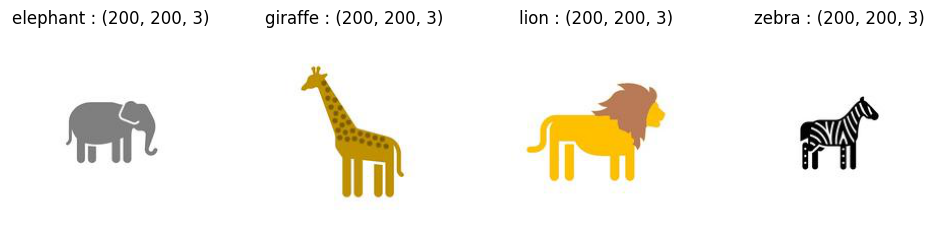

In [1]:
#Check what are in the data

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

data_path = 'data/safari/training'

classes = os.listdir(data_path)
classes.sort
print(len(classes), 'classes: ')
print(classes)

fig = plt.figure(figsize=(12,12))
i = 0
for subdir in os.listdir(data_path):
    i += 1
    imgfile = os.listdir(os.path.join(data_path, subdir))[0]
    imgpath = os.path.join(data_path, subdir, imgfile)
    img = mpimg.imread(imgpath)
    img_shape = np.array(img).shape
    a = fig.add_subplot(1, len(classes), i)
    a.axis('off')
    implot = plt.imshow(img)
    a.set_title(subdir + ' : ' + str(img_shape))
plt.show()

# Pytorch

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as td
import torchvision
import torchvision.transforms as transforms

In [3]:
#Function to ingest data and split the incoming data to training and validation set

def dataset(data_path):
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    train_size = int(0.7 * len(dataset))
    validation_size = len(dataset) - train_size
    training_data, validation_data = td.random_split(dataset, [train_size, validation_size])
    
    training_set = td.DataLoader(
        training_data,
        batch_size=50,
        num_workers=1,
        shuffle=False
    )
    
    validation_set = td.DataLoader(
        validation_data,
        batch_size=50,
        num_workers=1,
        shuffle=False
    )
    
    return training_set, validation_set

train_loader, validation_loader = dataset(data_path)

In [4]:
#Build the CNN model

class ConvNN(nn.Module):
    def __init__(self, num_classes=4):
        super(ConvNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        self.drop = nn.Dropout2d(p=0.2)
        
        self.fc = nn.Linear(in_features=50*50*24, out_features=num_classes)
        
    def forward(self, x):
        x = F.relu(self.maxpool(self.conv1(x)))
        x = F.relu(self.maxpool(self.conv2(x)))
        x = F.relu(self.drop(self.conv3(x)))
        
        x = F.dropout(x, training=self.training)
        
        x = x.view(-1, 50 * 50 * 24)
        
        x = self.fc(x)
        
        return F.log_softmax(x, dim=1)

In [5]:
# Train the model

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    
    print('Epoch - '+str(epoch))

    for batchidx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = model(data)
        loss = loss_criteria(output, target)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        if batchidx % 10 == 0:
            print('Progress: {}/{} ({:.0f}%), Current Loss: {:.6f}'.format(
                batchidx * len(data), len(train_loader.dataset), 100.0 * batchidx / len(train_loader), loss.item()))

    avg_loss = train_loss / (batchidx+1)
    print('Training set average loss: {:.6f}'.format(avg_loss))
    
    return avg_loss
    
def validation(model, device, validation_loader):
    model.eval()
    val_loss = 0
    correct = 0
    
    with torch.no_grad():
        batch_count = 0
        
        for data, target in validation_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += loss_criteria(output, target).item()
            
            _, pred = torch.max(output.data, 1)
            correct += torch.sum(target==pred).item()
            
    avg_loss = val_loss / batch_count
    print('Validation set average loss: {:.6f}, correct prediction: {}/{} ({:.6f}%)\n'.format(
        avg_loss, correct, len(validation_loader.dataset), correct / len(validation_loader.dataset)))
    
    return avg_loss
          
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    
model = ConvNN(num_classes=len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_criteria = nn.CrossEntropyLoss()

epoch_num = []
training_loss = []
validation_loss = []

epochs = 5
for epoch in range(1, epochs+1):
    epoch_num.append(epoch)
    train_loss = train(model, device, train_loader, optimizer, epoch)
    training_loss.append(train_loss)
    val_loss = validation(model, device, validation_loader)
    validation_loss.append(val_loss)

Epoch - 1


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Progress: 0/277 (0%), Current Loss: 1.388754
Training set average loss: 1.315130
Validation set average loss: 0.959317, correct prediction: 82/119 (0.689076%)

Epoch - 2
Progress: 0/277 (0%), Current Loss: 1.063668
Training set average loss: 0.699442
Validation set average loss: 0.293209, correct prediction: 116/119 (0.974790%)

Epoch - 3
Progress: 0/277 (0%), Current Loss: 0.389585
Training set average loss: 0.202517
Validation set average loss: 0.056032, correct prediction: 119/119 (1.000000%)

Epoch - 4
Progress: 0/277 (0%), Current Loss: 0.044956
Training set average loss: 0.032941
Validation set average loss: 0.007432, correct prediction: 119/119 (1.000000%)

Epoch - 5
Progress: 0/277 (0%), Current Loss: 0.016333
Training set average loss: 0.011641
Validation set average loss: 0.002846, correct prediction: 119/119 (1.000000%)



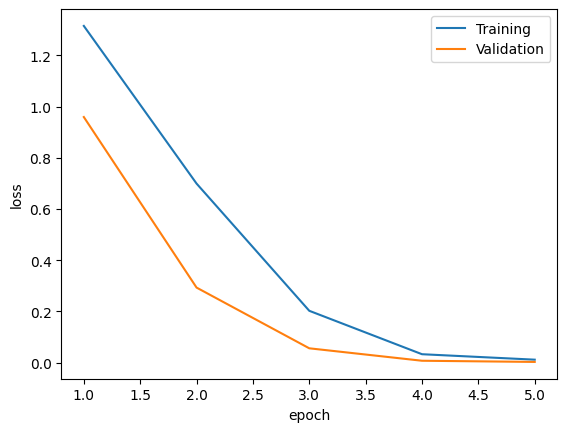

In [6]:
#Visualize the loss

plt.plot(epoch_num, training_loss)
plt.plot(epoch_num, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

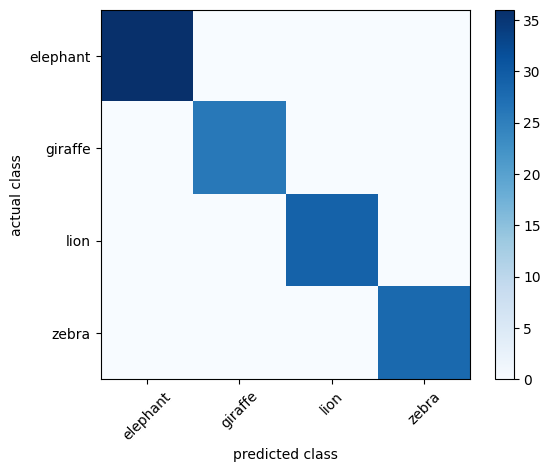

In [7]:
#Evalute in confusion matrix

from sklearn.metrics import confusion_matrix

model.eval()

pred_label = []
true_label = []

for data, target in validation_loader:
    for label in target.cpu().data.numpy():
        true_label.append(label)
    for pred in model.cpu()(data).data.numpy().argmax(1):
        pred_label.append(pred)

cm = confusion_matrix(true_label, pred_label)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick = np.arange(len(classes))
plt.xticks(tick, classes, rotation=45)
plt.yticks(tick, classes)
plt.xlabel('predicted class')
plt.ylabel('actual class')
plt.show()

In [9]:
#Save the model

model_file = 'models/PytorchConvNNExe.pt'
torch.save(model.state_dict(), model_file)
del model

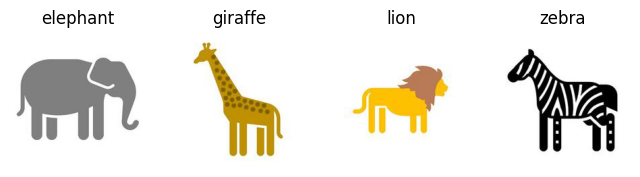

In [10]:
#Use the trained model
#Function to predict the class of an image

def predict_image(classifier, image):
    import numpy
    
    # Default value
    index = 0
    
    # !!Add your code here to predict an image class from your model!!
    classifier.eval()
    
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    image_tensor = transformation(image).float()
    
    image_tensor = image_tensor.unsqueeze(0)
    
    output = classifier(image_tensor)
    
    index = output.data.numpy().argmax()
    
    # Return the predicted index
    return index


# Load the model
model = ConvNN(len(classes))
model.load_state_dict(torch.load(model_file))

test_data_path = 'data/safari/test'

fig = plt.figure(figsize=(8,12))
i = 0
for imgfile in os.listdir(test_data_path):
    i += 1
    imgpath = os.path.join(test_data_path, imgfile)
    img = mpimg.imread(imgpath)
    index = predict_image(model, np.array(img))
    a = fig.add_subplot(1, len(classes), i)
    imgplot = plt.imshow(img)
    a.axis('off')
    a.set_title(classes[index])
plt.show()

# TensorFlow

In [22]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [32]:
#Create the train and test dataset

img_size = (200,200)
batch_size = 30

datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.3)

train_dataset = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_dataset = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

classes = list(train_dataset.class_indices.keys())
classes

Found 280 images belonging to 4 classes.
Found 116 images belonging to 4 classes.


['elephant', 'giraffe', 'lion', 'zebra']

In [13]:
#Create the NN model

model = Sequential()

model.add(Conv2D(32, (6, 6), input_shape=train_dataset.image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
          
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(train_dataset.num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

2024-04-25 22:12:12.277537: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 195, 195, 32)      3488      
                                                                 
 max_pooling2d (MaxPooling2  (None, 97, 97, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        36896     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 46, 46, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        36896     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 20, 20, 32)        0

In [14]:
#Train the model

num_epochs = 5
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // batch_size,
    validation_data=val_dataset,
    validation_steps=val_dataset.samples // batch_size,
    epochs=num_epochs
)

Epoch 1/5
9/9 [==============================] - 16s 2s/step - loss: 1.1831 - accuracy: 0.4760 - val_loss: 0.5540 - val_accuracy: 1.0000
Epoch 2/5
9/9 [==============================] - 16s 2s/step - loss: 0.2283 - accuracy: 0.9640 - val_loss: 0.0113 - val_accuracy: 1.0000
Epoch 3/5
9/9 [==============================] - 14s 2s/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 4/5
9/9 [==============================] - 17s 2s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.5994e-04 - val_accuracy: 1.0000
Epoch 5/5
9/9 [==============================] - 15s 2s/step - loss: 1.3192e-04 - accuracy: 1.0000 - val_loss: 5.7560e-05 - val_accuracy: 1.0000


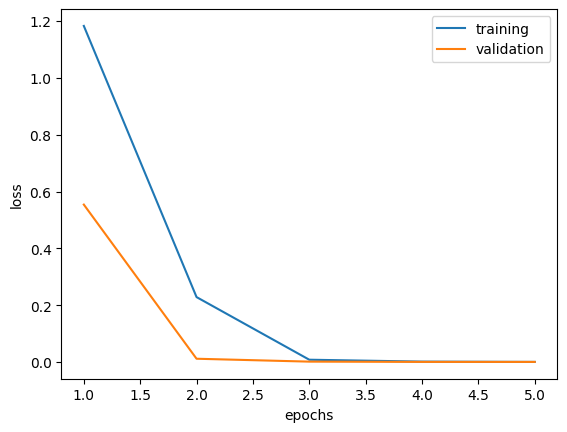

In [15]:
import matplotlib.pyplot as plt

epochs_num = range(1, num_epochs+1)
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
plt.plot(epochs_num, training_loss)
plt.plot(epochs_num, validation_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training','validation'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 333ms/step


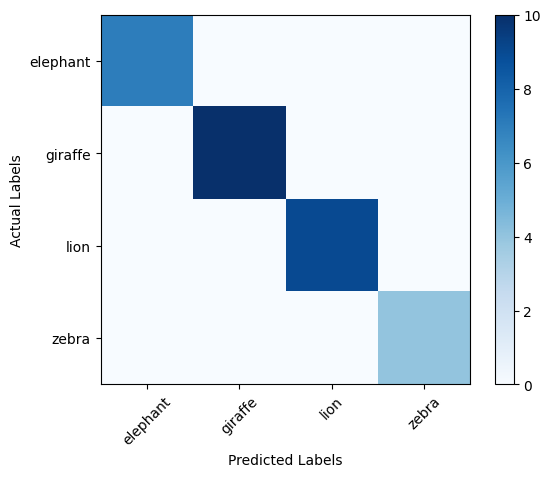

In [16]:
#Evaluate in confusion matrix

import numpy as np
from sklearn.metrics import confusion_matrix

x_test = val_dataset[0][0]
y_test = val_dataset[0][1]

class_prob = model.predict(x_test)
pred = np.argmax(class_prob, axis=1)

true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(true_labels, pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

In [17]:
#Save the model

modelFileName = 'models/animal_classifier.h5'
model.save(modelFileName)
del(model)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 73ms/step
0
1/1 [==============================] - 0s 27ms/step
1
1/1 [==============================] - 0s 28ms/step
2
1/1 [==============================] - 0s 24ms/step
3


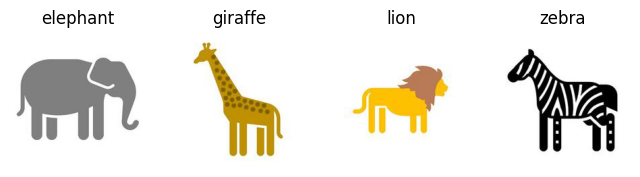

In [33]:
#Perform prediction

def predict_image(classifier, image):
    image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
    image = image.astype('float32')
    image /= 255
    
    class_prob = classifier.predict(image)
    pred = int(np.argmax(class_prob, axis=1)[0])
    
    return pred

model = models.load_model(modelFileName)

test_data_path = 'data/safari/test'

fig = plt.figure(figsize=(8, 12))
i = 0
for subdir in os.listdir(test_data_path):
    i += 1
    img_path = os.path.join(test_data_path, subdir)
    img_file = mpimg.imread(img_path)
    pred = predict_image(model, np.array(img_file))
    print(pred)
    a = fig.add_subplot(1, len(classes), i)
    a.axis('off')
    img = plt.imshow(img_file)
    a.set_title(classes[pred])
plt.show()